In [28]:
import matplotlib.pyplot as plt
import numpy as np
import ripleyk
import locan as lc
from scipy.spatial.distance import pdist
from scipy.spatial import ConvexHull, Delaunay
from scipy.spatial import cKDTree
import pandas as pd
from tqdm import tqdm

In [29]:
df = pd.read_parquet('/Users/swarchol/Research/bed/data/clustering.parquet')

In [30]:
df['cluster_2d'].value_counts().keys().tolist()

[23,
 -1,
 72,
 68,
 19,
 51,
 74,
 13,
 37,
 58,
 14,
 0,
 70,
 43,
 64,
 71,
 22,
 11,
 27,
 62,
 30,
 53,
 5,
 48,
 56,
 21,
 55,
 39,
 38,
 45,
 59,
 20,
 54,
 69,
 67,
 36,
 9,
 3,
 29,
 50,
 40,
 76,
 66,
 42,
 44,
 46,
 52,
 60,
 63,
 77,
 75,
 33,
 12,
 25,
 31,
 73,
 1,
 34,
 47,
 41,
 65,
 6,
 28,
 4,
 18,
 35,
 17,
 24,
 61,
 2,
 16,
 10,
 15,
 26,
 57,
 49,
 32,
 7,
 8]

In [31]:
df['cluster_2d'].value_counts()

cluster_2d
 23    284483
-1      98613
 72     81757
 68     54103
 19     38771
        ...  
 57       346
 49       339
 32       314
 7        314
 8        279
Name: count, Length: 79, dtype: int64

In [32]:
data = df[df['cluster_2d'] == 57][['X_centroid', 'Y_centroid']].values

In [33]:
def num_pairwise(x):
    return ((x ** 2) / 2  - x/2)

def manual_ripley(data):
    distances = pdist(data)
    return distances

def calculate_ripley_h(k, radaii):
    l_estimate = np.sqrt(k / np.pi)
    h_estimate = l_estimate - radaii
    return h_estimate


def calculate_ripley_k(distances, radaii, density, n):
    n_pairs_less_than_d = (distances < radaii.reshape(-1, 1))
    n_pairs_less_than_d_sum = n_pairs_less_than_d.sum(axis=1)
    k_estimate = ((n_pairs_less_than_d_sum * 2) / n) / density
    return k_estimate, n_pairs_less_than_d_sum[-1]


def k_function_subsample(distances, radii, n, density, f):
    n_pairs_less_than_d = (distances < radii.reshape(-1, 1)).sum(axis=1)
    k_estimate = ((n_pairs_less_than_d * 2) / n) / density
    
    # Adjust for subsampling factor
    k_estimate *= (1 / f)
    
    return k_estimate

def subsample_k_by_random_pairs(data, n_pairs):
    # Determine subsample_size pairs of points in data
    pairs = np.random.choice(data.shape[0], (n_pairs, 2))
    # make sure that the same point is not selected twice
    pair_distances = np.linalg.norm(data[pairs[:, 0]] - data[pairs[:, 1]], axis=1)
    # drop distances that are 0
    # print('diff', pair_distances[pair_distances != 0].shape[0] - pair_distances.shape[0])
    pair_distances = pair_distances[pair_distances != 0]
    return pair_distances



100%|██████████| 79/79 [00:07<00:00, 11.25it/s]


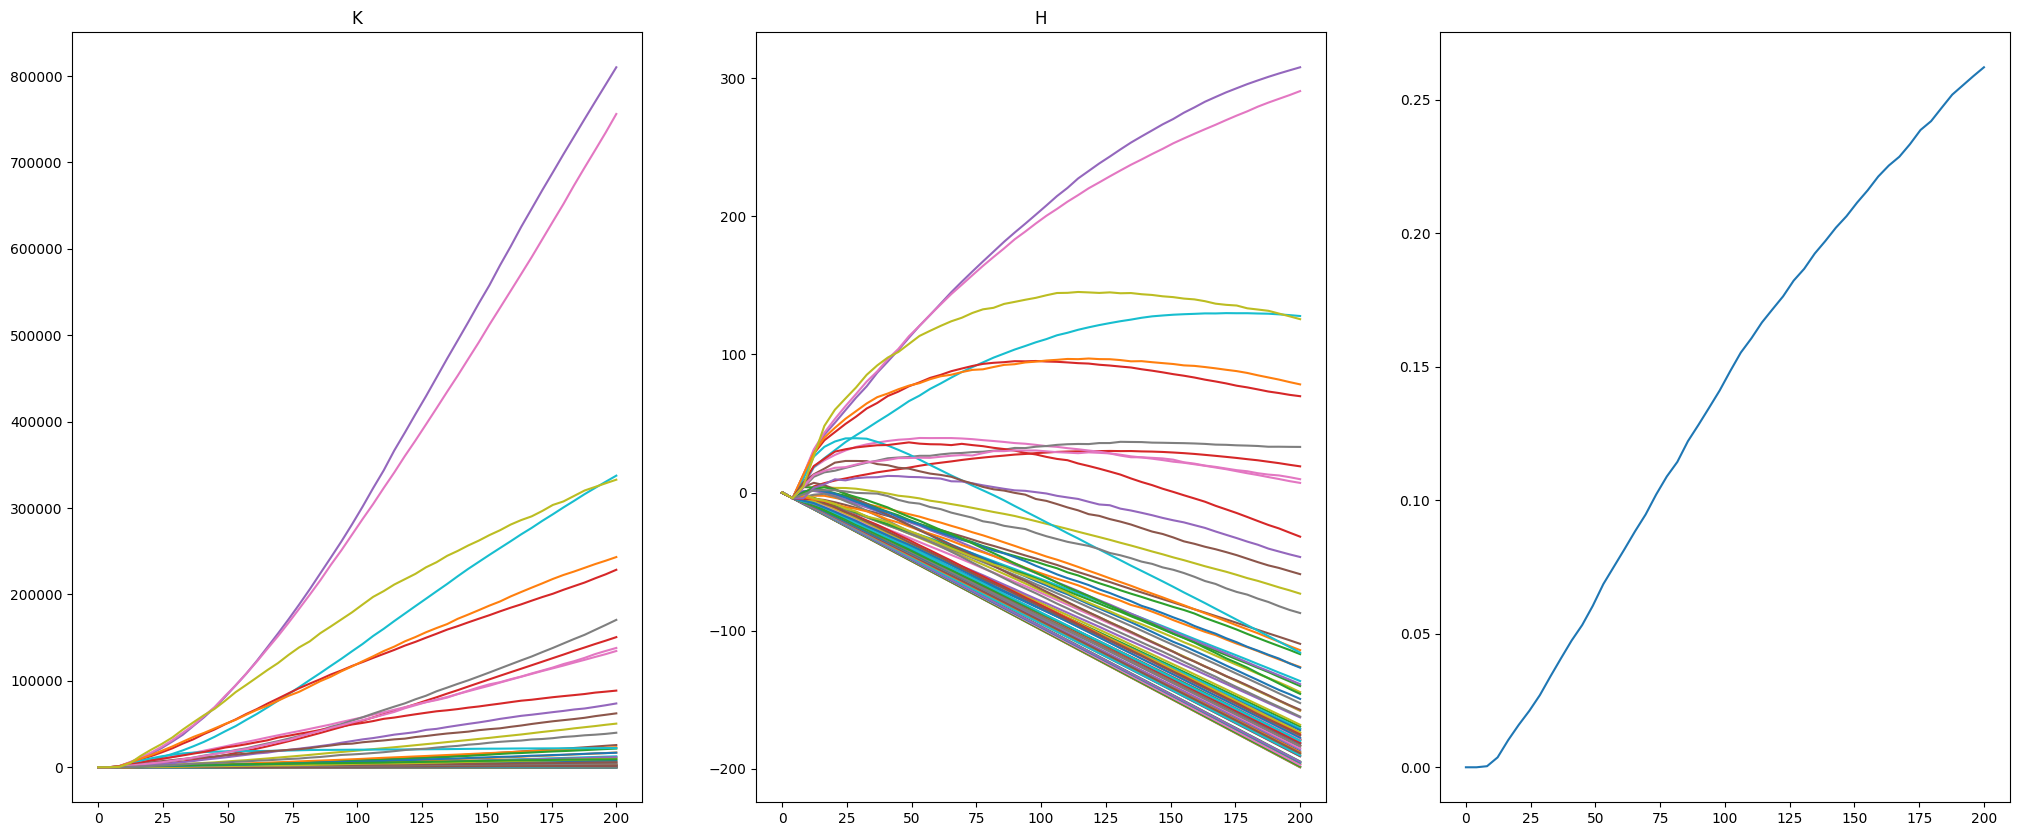

In [34]:
radius = 200
radaii = np.linspace(0, radius, 50)
subsample_size = 1000000
all_coordinates = df[["X_centroid", "Y_centroid"]].values
N = all_coordinates.shape[0]
hull = ConvexHull(all_coordinates)
area = hull.volume
fig, ax = plt.subplots(1, 3, figsize=(25, 10))
for cluster in tqdm(df["cluster_2d"].value_counts().keys().tolist()):
    data = df[df["cluster_2d"] == cluster][["X_centroid", "Y_centroid"]].values
    # hull = ConvexHull(data)
    # area = hull.volume
    density = data.shape[0] / area
    subsample_distances = subsample_k_by_random_pairs(data, subsample_size)
    k_random, num_valid = calculate_ripley_k(subsample_distances, radaii, density, N)
    ax[0].plot(radaii, k_random, label=cluster)
    h_random = calculate_ripley_h(k_random, radaii)
    ax[1].plot(radaii, h_random, label=cluster)

ax[0].set_title("K")
ax[1].set_title("H")


# # Create 3 plots for K, L, H


k = ripleyk.calculate_ripley(radaii.tolist(), 1, d1=data[:, 0], d2=data[:, 1])
ax[2].plot(radaii, k)




plt.show()